# Parcial 2: Luis Alejandro Baena Marin

In [107]:
from scipy.interpolate import splrep, BSpline, CubicSpline
from scipy.special import gammainc
from scipy.optimize import brentq
from numpy import prod, round, abs, array
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import math

# Establece la semilla para la generación de números aleatorios
np.random.seed(1)
x = np.random.normal(size=100, loc=2)
y = np.random.normal(size=100, loc=5)

# Función que calcula una funció de un conjunto de datos
def T(x):
  return mean(x)

# Función para calcular la media aritmética de un arreglo
def mean(x) -> float:
  return sum(x)/len(x)

# Función que calcula la media cuadrática (RMS) de un arreglo
def sq_mean(x) -> float:
  return np.sqrt(sum(x**2)/len(x))

# Función para calcular la media geométrica
def geo_mean(x) -> float:
  return (np.prod(x))**(1/len(x))

# Función para calcular la media ponderada de un arreglo, dada una lista de pesos
def w_mean(w, x) -> float:
  if np.round(sum(w),3) != 1.000:
    raise ValueError("Weights must sum to 1")
  return sum((x*w))

# Función para calcular la media truncada, que elimina el porcentaje 'alpha' de los valores extremos
def trim_mean(x, alpha) -> float:
  if alpha >= 0.5 or alpha <= 0:
    raise ValueError("Alpha must be less than 0.5 and greater than 0")
  p = (alpha/2)*len(x)
  return np.mean(np.sort(x)[int(p):-int(p)])

# Función que calcula la mediana de un conjunto de datos
def median(x):
  n = len(x)
  x = sorted(x)
  if n % 2 == 1:
    return x[(n+1)//2-1]
  else:
    return (x[n//2] + x[n//2-1])/2

# Función para calcular la desviación estándar (corregida)
def sd(x):
  x_bar = sum(x)/len(x)
  return ((sum((x-x_bar)**2)/(len(x)-1))**(1/2))

# Función que calcula la desviación absoluta mediana (MAD)
def mad(x, k = 1/0.6745):
  x_tilde = median(x)
  return k*median(np.abs(x-x_tilde))

# Coeficiente de corrección calculado como la relación entre la desviación estándar y el MAD
md = mad(x, k=1)
k = sd(x)/md

# Función que calcula la covarianza entre dos conjuntos de datos
def cov(x, y):
  if len(x) == len(y):
    x_bar = mean(x)
    y_bar = mean(y)
    n = len(x)
    return(sum((x-x_bar)*(y-y_bar))/(n-1))
  else:
    return("Los vectores tienen que tener el mismo largo")

# Función que calcula la covarianza robusta usando medianas
def com(x, y):
  x_median = median(x)
  y_median = median(y)
  return(median((x-x_median)*(y-y_median)))

# Función que calcula el coeficiente de correlación de Pearson
def corr_pearson(x, y):
  return(cov(x, y)/(sd(x)*sd(y)))

# Función que calcula el coeficiente de correlación robusto usando MAD
def corr_com(x, y):
  return(com(x, y)/(mad(x, k=1)*mad(y, k=1)))

# Función para obtener el ranking de los valores de un conjunto de datos
def rank(x):
  x_rank2 = []
  x_sort = sorted(x)
  for i in range(len(x)):
    x_rank2.append(x_sort.index(x[i]) + 1)
  return(np.array(x_rank2))

# Función que calcula el coeficiente de correlación de Spearman
def rho_spearman(x, y):
  n = len(x)
  return(1-((6*sum((rank(x) - rank(y))**2))/(n*((n**2)-1))))

# Función que calcula el coeficiente de correlación de Kendall
def corr_kendall(x,y):
    if len(x) != len(y):
        raise ValueError("Arguments have unequal length")
    c = 0
    d = 0
    new_x, new_y = zip(*sorted(zip(x, y)))
    for i in range(len(x)):
        for j in range(i+1,len(x)):
            if new_y[i] <= new_y[j]:
                c+=1
            else:
                d+=1
    return (c-d)/(c+d)

# Función que calcula el estimador T-barra usando Jackknife
def t_bar(data, estimator, robust):
    estimations = []
    for i in range(len(data)):
        newlist = data.copy()
        del newlist[i]
        estimations.append(estimator(newlist))
    if robust:
        return np.median(estimations)
    return np.mean(estimations)

# Función que calcula el sesgo de Jackknife
def bias_jackknife(data, estimator, robust=False):
    data = list(data)
    mean_t = t_bar(data, estimator, robust)
    return (len(data)-1) * (mean_t - estimator(data))

# Función que calcula un estimador Jackknife robusto o no
def jackknife_estimator_especifico(data, estimator, robust=False):
    data = np.array(data)
    T_data = estimator(data)
    T_vector = np.empty(len(data))

    for i in range(len(data)):
        T_excluded = estimator(np.delete(data, i))
        T_vector[i] = len(data) * T_data - (len(data) - 1) * T_excluded

    if robust:
        return np.median(T_vector), T_vector
    return np.mean(T_vector), T_vector

# Función que calcula varios estimadores Jackknife
def jackknife_estimator_general(x, T):
  Tn = T(x)
  n = len(x)
  T_tildes = []
  for i in range(len(x)):
    lista = list(x)
    lista.pop(i)
    T_tildes.append(n*Tn-(n-1)*T(np.array(lista)))

  T_tildes = np.array(T_tildes)
  T_jack = mean(T_tildes)

  s2_tilde = sum((T_tildes - mean(T_tildes))**2)/(n-1)
  Var_T_jack = s2_tilde/n

  return ({"T_tildes": T_tildes, "Estimador": T_jack, "Var_estimador": Var_T_jack})

# Método Bootstrap a un estimador para obtener su distribución, estimación promedio y varianza
def bootstrap_estimator(x, T, B=500):
    n = len(x)
    x = np.array(x)
    T_boots = []

    for _ in range(B):
        x_resample = np.random.choice(x, size=n)
        T_boots.append(T(x_resample))

    T_boots = np.array(T_boots)

    T_boot = mean(T_boots)
    var_boot = mean((T_boots - mean(T_boots))**2)
    return {"distro": T_boots, "Estimador": T_boot, "VarEstimator": var_boot}

# Función de distribución empírica (ECDF) de un conjunto de datos
def ECDF(x):
    n = len(x)
    x = sorted(x)
    ECDF_list = []
    for i in range(len(x)):
        ECDF_list.append(i/n)
    return [x, ECDF_list]

# Calcula el percentil de un conjunto de datos
def percentile(data, percent):
    if percent < 0 or percent > 100:
        raise ValueError("Percent debe estar entre 0 y 100")

    data = np.sort(data)
    index = (len(data) - 1) * (percent / 100)
    lower = int(np.floor(index))
    upper = int(np.ceil(index))

    if lower == upper:
        return data[lower]
    else:
        return data[lower] + (data[upper] - data[lower]) * (index - lower)

# Calcula el intervalo de confianza del 95% de un estimador basado en la distribución bootstrap
def confidence_interval(bootstrap_dist, confidence=0.95):
    lower_percentile = (1 - confidence) / 2
    upper_percentile = 1 - lower_percentile
    ci_lower = percentile(bootstrap_dist, lower_percentile * 100)
    ci_upper = percentile(bootstrap_dist, upper_percentile * 100)
    return (ci_lower, ci_upper)

# Weighted least squares (WLS)
def WLS(x, y, w = None):
  if (len(x.shape) == 1):
    x = x.reshape(-1,1)

  # Matriz de diseño: matrix "x" aumentada con columna de unos
  X = np.concatenate([np.ones((len(x),1)), x], axis = 1)
  n, p = X.shape
  if w is None:
    w = np.eye(n)

  left = np.linalg.inv(np.matmul(np.matmul(np.transpose(X), w), X))
  right = np.matmul(np.matmul(np.transpose(X), w), y)
  beta = np.matmul(left, right)

  return beta




#print(f"Mean: {mean(x)}")
#print(f"Square mean: {sq_mean(x)}")
#print(f"Geometric mean: {geo_mean(x)}")
w=np.random.uniform(1,100,size=len(x)); w/=sum(w);
#print(f"Weighted mean: {w_mean(w, x)}")
alpha = 0.2
#print(f"Alpha: {alpha}. Trim mean: {trim_mean(x, alpha)}")
#print(f"Mediana (Q2): {median(x)}")
#print(f"Standard Deviation: {sd(x)}")
#print(f"MAD: {mad(x, k=1)}")
#print(f"Coeficiente de corrección: {k}")
#print(f"Pearson: {corr_pearson(x,y)}")
#print(f"Spearman: {rho_spearman(x,y)}")
#print(f"Kendall: {corr_kendall(x,y)}")
#print(f"Bias Jackknife: {bias_jackknife(x, T)}")
#print(f"Jackknife especifico 1: {jackknife_estimator_especifico(x, T, robust=True)[0]}")
#print(f"Jackknife general 2: {jackknife_estimator_general(x, T)['Estimador']}")
boots = bootstrap_estimator(x, T)
#print(f"Estimador Boostrap para sd: {round(boots['Estimador'],4)}")
#print(f"Varianza del estimador: {round(boots['VarEstimator'],4)}")
#plt.hist(boots["distro"])
#plt.plot(ECDF(x)[0], ECDF(x)[1])
median_boot = bootstrap_estimator(x, T)
ci_lower, ci_upper = confidence_interval(median_boot["distro"])
#print(f"I.C 95%: [{round(ci_lower, 3)}, {round(ci_upper, 3)}]")
#x = np.random.multivariate_normal(mean = [0,0,0], cov = [[1,0,0],[0,1,0],[0,0,1]],size=n)
#e = np.random.normal(loc = 0, scale = 1.2, size = n)
#y = 1 + 2*x[:,0] + 3*x[:,1] + 4*x[:,2] + e
#pint(f"Coeficcients WLS: {WLS(x,y)}")

### EJERCICIO 1

In [223]:
def g(x):
    return x**3

def dg(x):
    return 3*(x**2)

def Tn(data):
    return g(np.mean(data))

def sigma_n(data, mu, var):
    temp = dg(mu)**2 * var
    return (temp / len(data)) ** (1/2)

def ecdf(x):
    x = sorted(x)
    ecdf = []
    n = len(x)
    for i in range(n):
        ecdf.append(i/n)
    return x, ecdf

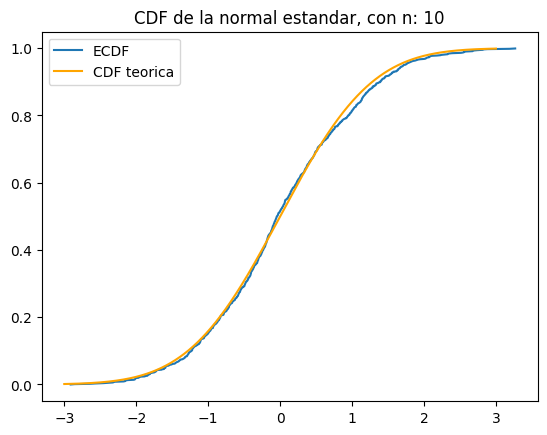

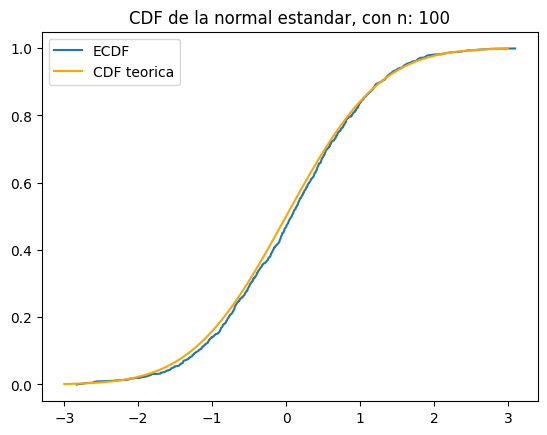

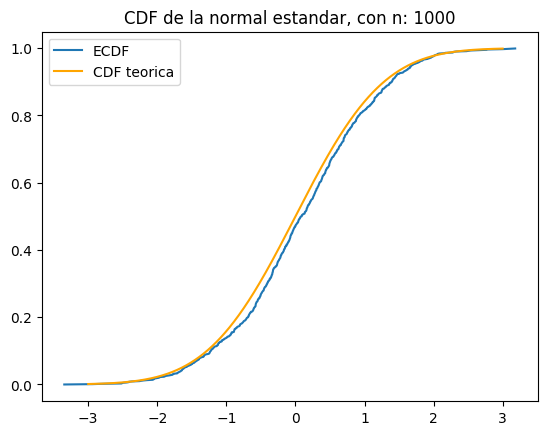

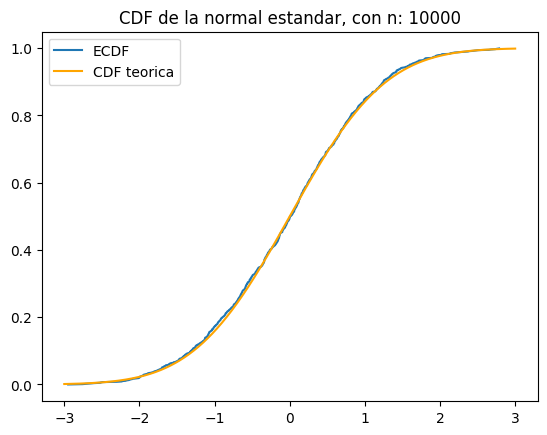

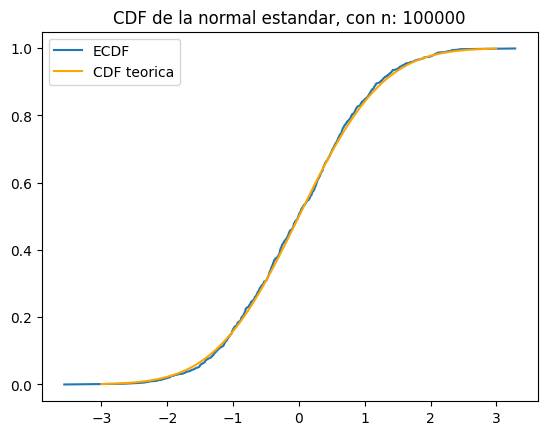

In [225]:
from scipy.stats import norm #cdf de la normal estandar

mu = 50
var = 6

x = np.arange(-3, 3, 0.001)
cdf_teor = norm.cdf(x, loc=0, scale=1)

for n in [10, 100, 1000, 10000, 100000]:
    aprox_estandar = []
    for i in range(1000):
        data = np.random.normal(loc = 50, scale =  np.sqrt(6),size = n)
        est = (Tn(data)-g(mu))/sigma_n(data, mu, var)
        aprox_estandar.append(est)
    x_sim, cdf_sim = ecdf(aprox_estandar)
    plt.figure()
    plt.plot(x_sim,cdf_sim)
    plt.plot(x, cdf_teor, color = "orange")
    plt.title(f"CDF de la normal estandar, con n: {n}")
    plt.legend(["ECDF","CDF teorica"])
    plt.show()

### Bono: Probar consistencia

v_jack / sigma_n_squared = 1.0398758703724618


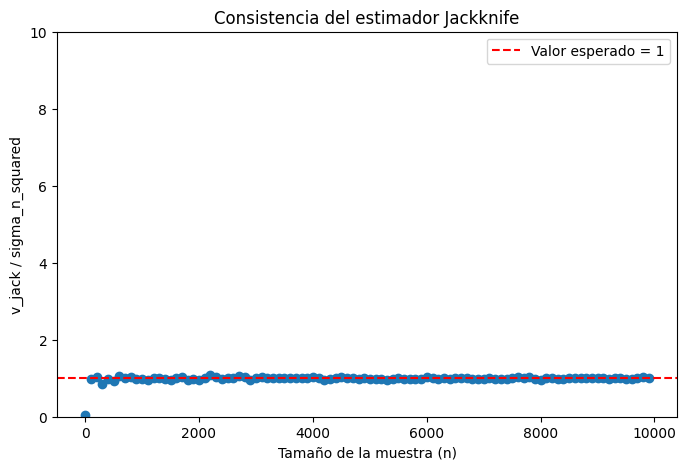

In [13]:
# Parámetros
n = 1000  # Tamaño de la muestra
mu = 50    # Media verdadera
sigma = 6 # Desviación estándar verdadera

# Generar muestra aleatoria
X = np.random.normal(mu, sigma, n)

# Definir la función g y su derivada en mu
def g(x):
    return x**3

def g_prime(mu):
    return 3*mu**2

# Calcular Tn y g(mu)
X_bar = np.mean(X)
Tn = g(X_bar)
g_mu = g(mu)

# Calcular sigma_n^2
sigma_n_squared = (1 / n) * (g_prime(mu))**2 * sigma**2

# Implementar el Jackknife
T_jackknife = np.zeros(n)
for i in range(n):
    # Muestra sin el i-ésimo dato
    X_leave_one_out = np.delete(X, i)
    X_bar_leave_one_out = np.mean(X_leave_one_out)
    T_jackknife[i] = g(X_bar_leave_one_out)

# Calcular el estimador Jackknife de la varianza
v_jack = ((n - 1) / n) * np.sum((T_jackknife - Tn)**2)

# Verificar la consistencia
consistency_ratio = v_jack / sigma_n_squared
print(f"v_jack / sigma_n_squared = {consistency_ratio}")

# Repetir el experimento para diferentes tamaños de muestra
n_values = np.arange(2,10000, 100)
consistency_ratios = []

for n in n_values:
    X = np.random.normal(mu, sigma, n)
    X_bar = np.mean(X)
    Tn = g(X_bar)
    sigma_n_squared = (1 / n) * (g_prime(mu))**2 * sigma**2

    T_jackknife = np.zeros(n)
    for i in range(n):
        X_leave_one_out = np.delete(X, i)
        X_bar_leave_one_out = np.mean(X_leave_one_out)
        T_jackknife[i] = g(X_bar_leave_one_out)

    v_jack = ((n - 1) / n) * np.sum((T_jackknife - Tn)**2)
    consistency_ratio = v_jack / sigma_n_squared
    consistency_ratios.append(consistency_ratio)

# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.scatter(n_values, consistency_ratios)
plt.axhline(1, color='r', linestyle='--', label='Valor esperado = 1')
plt.xlabel('Tamaño de la muestra (n)')
plt.ylabel('v_jack / sigma_n_squared')
plt.title('Consistencia del estimador Jackknife')
plt.ylim(0, 10)
plt.legend()
plt.show()

#### Ejercicio 2

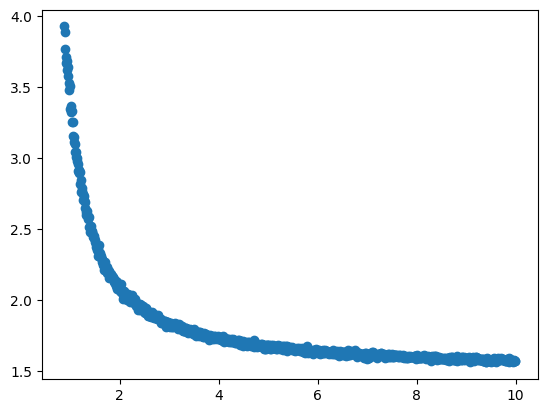

In [198]:
N = 100
k = np.zeros(N)
DF = np.arange(0.88, 10, 0.01)
k_mean = np.zeros(len(DF))
for j, df in enumerate(DF):
    for i in range(N):
        x = np.random.chisquare(df, size = 500)
        k[i] = np.std(x)/mad(x,1)

    k_mean[j] = np.mean(k)

plt.scatter(DF, k_mean)

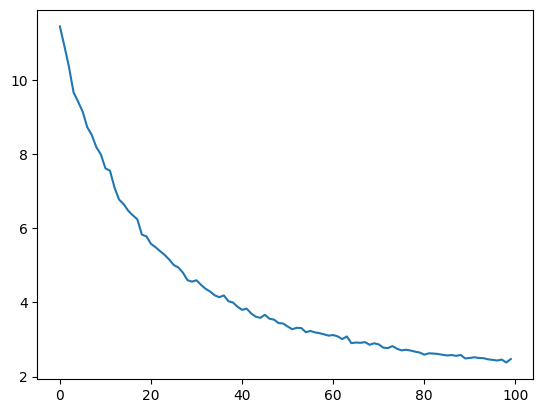

In [54]:
plt.plot(k_mean[:100])

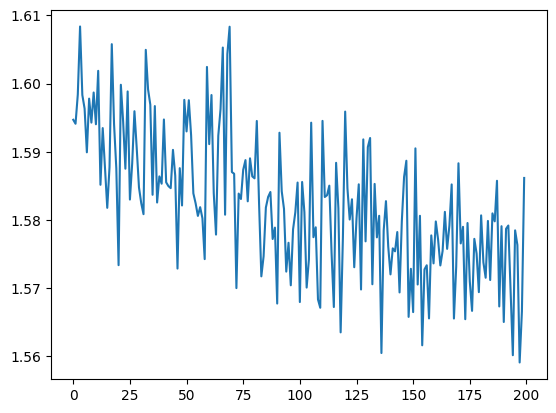

In [56]:
plt.plot(k_mean[-200:])

In [230]:
print(f"Factor de correción K: {k_mean[-1]}")

Factor de correción K: 1.5684962277233399


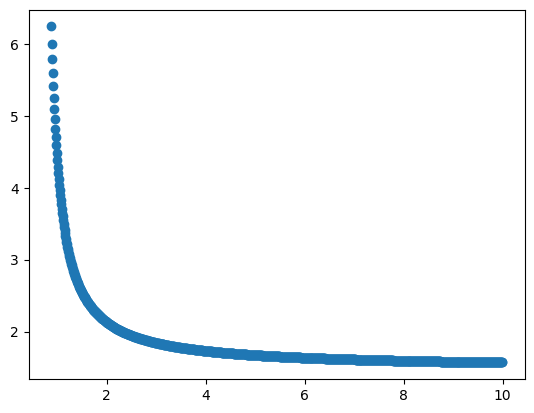

In [190]:
def g(x):
    arg1 = (x + df - 2/3) / 2
    arg2 = (-x + df - 2/3) / 2
    arg1 = max(0.01, arg1)  # > 0
    arg2 = max(0, arg2)  # >=0

    return (gammainc(df/2, arg1)) - (gammainc(df/2, arg2)) - 1/2

k1=[]
DF = np.arange(0.88, 10, 0.01)
for df in np.arange(0.88, 10, 0.01):
  x_a = brentq(g, 0, 300)
  k1.append(np.sqrt(2*df)/x_a)

plt.scatter(DF, k1)

In [191]:
print(f"Factor de correción K: {k1[-1]}")

Factor de correción K: 1.569905205827842


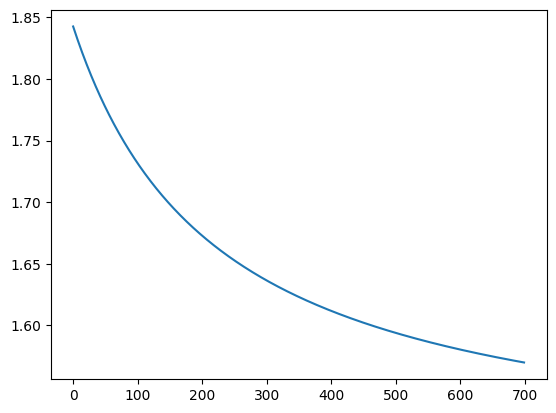

In [234]:
plt.plot(k1[-700:])

In [ ]:
plt.scatter(DF, k_mean)
plt.scatter(DF, k1)
plt.show()

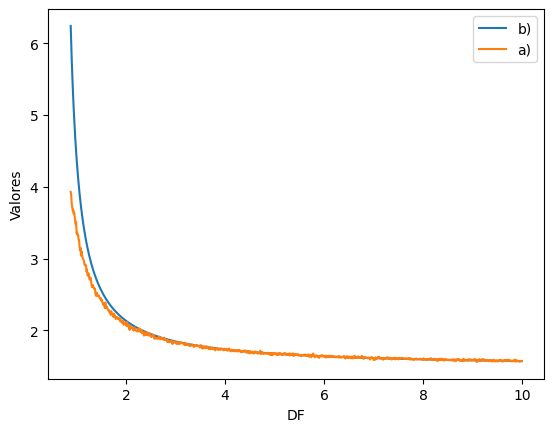

In [206]:

# Primera parte del código
DF1 = np.arange(0.88, 10, 0.01)
plt.plot(DF1, k1, label='b)')

DF2 = np.arange(0.88, 10, 0.01)
plt.plot(DF2, k_mean, label='a)')

# Añadir etiquetas y leyenda
plt.xlabel('DF')
plt.ylabel('Valores')
plt.legend()

# Mostrar gráfico
plt.show()

Análisis:
- Convergen a un valor similar, aprox ~ 1.5
- Como la primera estimación depende de una variable aleatoria normal, vemos que su convergencia tiene ruido
- El método números tienen un mejor desempeño en cuanto a tiempo de ejecución


### Ejercicio 3

In [164]:
from palmerpenguins import load_penguins

penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [165]:
#penguins = penguins[['bill_depth_mm', 'body_mass_g']]

In [166]:
penguins['bill_depth_mm'].fillna(penguins['bill_depth_mm'].median(), inplace = True)
penguins['body_mass_g'].fillna(penguins['body_mass_g'].median(), inplace = True)

C:\Users\alejo\AppData\Local\Temp\ipykernel_22884\738574561.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  penguins['bill_depth_mm'].fillna(penguins['bill_depth_mm'].median(), inplace = True)
C:\Users\alejo\AppData\Local\Temp\ipykernel_22884\738574561.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [167]:
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,17.3,NaN,4050.0,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [168]:
corr_kendall(penguins['bill_depth_mm'], penguins['body_mass_g'])

-0.16760458336158385

In [169]:
corr_com(penguins['bill_depth_mm'], penguins['body_mass_g'])

-0.47777777777777686

In [171]:
corr_pearson(penguins['bill_depth_mm'], penguins['body_mass_g'])

-0.47194169569610084

In [172]:
rho_spearman(penguins['bill_depth_mm'], penguins['body_mass_g'])
#scipy.stats.spearmanr(penguins['bill_depth_mm'], penguins['body_mass_g'])

-0.43680293726619634

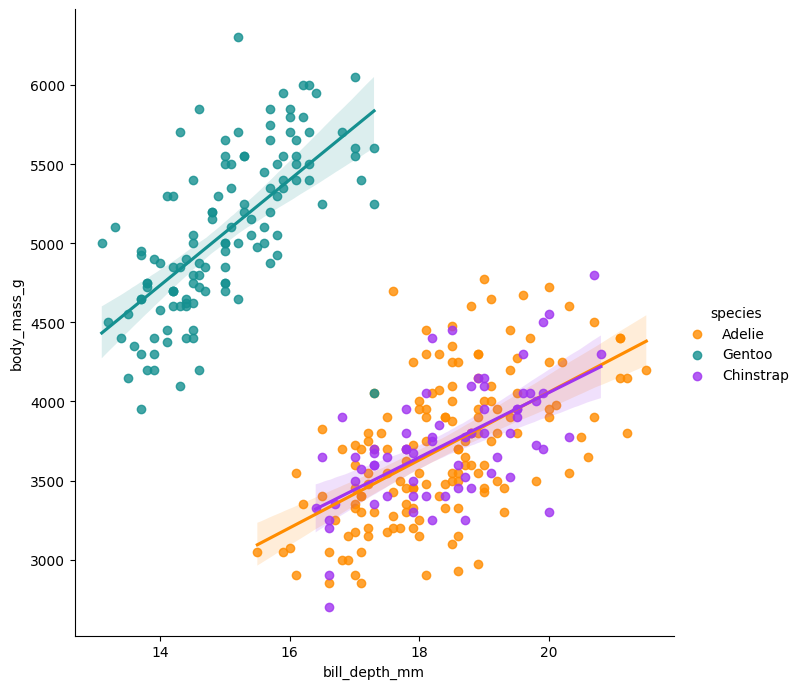

In [173]:
g = sns.lmplot(x="bill_depth_mm",
               y="body_mass_g",
               hue="species",
               height=7,
               data=penguins,
               palette=['#FF8C00','#159090','#A034F0'])
g.set_xlabels('bill_depth_mm')
g.set_ylabels('body_mass_g')

Análisis: 
- Todas las correlaciones dieron negativas, sin embargo, la correlación de Kendall dio ligeramente inferior que las demás. 
- La correlación comediana, y la pearson dieron casi identicas.
- La spearman dio un poco menos, pero igualmente cerca a las anteriores.

### Ejercicio 4

In [207]:
penguins['bill_length_mm'].fillna(penguins['bill_length_mm'].median(), inplace = True)
penguins['body_mass_g'].fillna(penguins['body_mass_g'].median(), inplace = True)

C:\Users\alejo\AppData\Local\Temp\ipykernel_22884\1161108824.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  penguins['bill_length_mm'].fillna(penguins['bill_length_mm'].median(), inplace = True)
C:\Users\alejo\AppData\Local\Temp\ipykernel_22884\1161108824.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [208]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.10,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.50,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.30,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,44.45,17.3,NaN,4050.0,NaN,2007
4,Adelie,Torgersen,36.70,19.3,193.0,3450.0,female,2007


In [218]:
def ecdf(x):
    x = sorted(x)
    ecdf = []
    n = len(x)
    for i in range(n):
        ecdf.append(i/n)
    return x, ecdf

def percentil(data, q):
    data, ecdf_data = ecdf(data)
    for i in range(len(ecdf_data)):
        if ecdf_data[i] >= q:
            return data[i]

def estimator_jackknife_2d(data1, data2, estimator, robust=False):
    data1 = np.array(data1)
    data2 = np.array(data2)
    T_data = estimator(data1, data2)
    T_vector = np.empty(len(data1))
    
    for i in range(len(data1)):
        T_excluded = estimator(np.delete(data1, i), np.delete(data2, i))
        T_vector[i] = len(data1) * T_data - (len(data1) - 1) * T_excluded

    if robust:
        return median(T_vector), T_vector
    return mean(T_vector), T_vector

In [235]:
T = rho_spearman
T_estimated, T_vector = estimator_jackknife_2d(penguins["bill_length_mm"], penguins["body_mass_g"],T)
n = len(penguins["bill_length_mm"])
sd_jack = sd(T_vector)/(n**(1/2))
# Intervalo de confianza
alpha = 0.05
z = 1.959964 #Cuantil alpha/2 de normal estandar
print(f"Estimador puntual: {T_estimated}")
print(f"Varianza del estimador: {sd_jack}")
print(f"Intervalo de confianza al {100 - alpha*100}%: [{T_estimated-z*sd_jack}, {T_estimated+z*sd_jack}]")

Estimador puntual: 0.583444527679419
Varianza del estimador: 0.039963082472222765
Intervalo de confianza al 95.0%: [0.5051183247048314, 0.6617707306540066]


b)

In [236]:
np.random.seed(123)

In [237]:
def bootstrap_estimator_2d(x, y, T, N = 1000):
    x = np.array(x)
    y = np.array(y)
    T_boots = []
    n = len(x)
    indexes = range(n)
    for i in range(N):
        index_resample = np.random.choice(indexes,n)
        x_resample = from_index(x, index_resample)
        y_resample = from_index(y, index_resample)
        #x_resample = np.random.choice(x,n)
        #y_resample = np.random.choice(y,n)
        T_boots.append(T(x_resample, y_resample))
    
    T_boots = np.array(T_boots)
    var_boot = mean((T_boots- mean(T_boots))**2)
    return {"Distro": T_boots, "Estimador": mean(T_boots), "VarEstimador": var_boot}

def from_index(x, indexes):
    res = []
    for e in indexes:
        res.append(x[e])
    return res

def percentil(data, q):
    data, ecdf_data = ecdf(data)
    for i in range(len(ecdf_data)):
        if ecdf_data[i] >= q:
            return data[i]

In [238]:
# Intervalo pivotal
T = rho_spearman
T_boot = bootstrap_estimator_2d(penguins["bill_length_mm"],penguins["body_mass_g"], T)
np.random.seed(123)
distrib = T_boot['Distro']
estimator = T_boot['Estimador']
alpha = 0.05
low = 2*estimator - percentil(distrib, 1-alpha/2)
up = 2*estimator - percentil(distrib, alpha/2)
print(f"Intervalo de confianza pivotal: [{low}, {up}]")

Intervalo de confianza pivotal: [0.5059314535694379, 0.6613240078177731]


Los intervalo de confianza dieron similares, sin embargo, el intervalo pivotal dio un poco más estrecho.